### Imports

In [9]:
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
from torchvision.utils import save_image
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import os
from skimage.io import imread

### Functions

In [24]:
def plot_metric(data, metric):
    plt.plot(data, label=metric)
    plt.legend()
    plt.show

def image_show(directory):
    a = imread(directory)
    plt.imshow(a)

def discriminator_network_creator():
    D = nn.Sequential(
        nn.Linear(784,512),
        nn.LeakyReLU(0.2),
        nn.Linear(512,256),
        nn.LeakyReLU(0.2),
        nn.Linear(256,1),
        # nn.Sigmoid(),
    )
    return D

def generator_network_creator(latent_dim=100):
    G = nn.Sequential(
        nn.Linear(latent_dim,256),
        nn.LeakyReLU(0.2),
        nn.BatchNorm1d(256,momentum=0.7),
        nn.Linear(256,512),
        nn.LeakyReLU(0.2),
        nn.BatchNorm1d(512,momentum=0.7),
        nn.Linear(512,1024),
        nn.LeakyReLU(0.2),
        nn.BatchNorm1d(1024,momentum=0.7),
        nn.Linear(1024,784),
        nn.Tanh(),
    ) 
    return G   

def scale_image(img):
    out = (img+1)/2
    return out

def load_model_and_train(train_loader,batch_size=128,n_epochs=10,latent_dim=100):
    D = discriminator_network_creator()
    G = generator_network_creator(latent_dim=latent_dim)

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(device)
    D.to(device)
    G.to(device)

    criterion = nn.BCEWithLogitsLoss()
    d_optimizer = torch.optim.Adam(D.parameters(), lr=0.0002, betas=(0.5,0.999))
    g_optimizer = torch.optim.Adam(G.parameters(), lr=0.0002, betas=(0.5,0.999))

    ones_ = torch.ones(batch_size, 1).to(device)
    zeros_ = torch.zeros(batch_size, 1).to(device)

    d_losses = []
    g_losses = []
    
    for it in range(n_epochs):
        t0 = datetime.now()
        for inputs, _ in train_loader:
            n = inputs.size(0)
            inputs = inputs.reshape(n,784).to(device)

            ones = ones_[:n]
            zeros = zeros_[:n]

            # real images
            real_outputs = D(inputs)
            d_loss_real = criterion(real_outputs, ones)

            # fake images
            noise = torch.randn(n, latent_dim).to(device)
            fake_images = G(noise)
            fake_outputs = D(fake_images)
            d_loss_fake = criterion(fake_outputs, zeros)

            # gradient descent step
            d_loss = 0.5 * (d_loss_real + d_loss_fake)
            d_optimizer.zero_grad()
            g_optimizer.zero_grad()
            d_loss.backward()
            d_optimizer.step()

            for _ in range(2):
                noise = torch.randn(n, latent_dim).to(device)
                fake_images = G(noise)
                fake_outputs = D(fake_images)
                g_loss = criterion(fake_outputs, ones)

                d_optimizer.zero_grad()
                g_optimizer.zero_grad()
                g_loss.backward()
                g_optimizer.step()


        
        d_losses.append(d_loss.item())
        g_losses.append(g_loss.item())

        # if it%10==0:

        dt = datetime.now() - t0
        print(f"Epoch {it+1}/{n_epochs}, D Loss: {d_loss.item():.4f}, G Loss: {g_loss.item():.4f} , Duration Time: {dt}")
        fake_images = fake_images.reshape(-1,1,28,28)
        save_image(scale_image(fake_images),f"gan_images/{it+1}.png")
        
    return D, G , d_losses, g_losses, device


def transform_creator():
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.5,), std=(0.5,))
    ])
    return transform 

### Create dataset

In [11]:
transform = transform_creator()

In [12]:
train_dataset = torchvision.datasets.MNIST(
    root=".",
    train=True,
    transform = transform,
    download=True
)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [13]:
len(train_dataset)

60000

In [14]:
batch_size = 128
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size = batch_size,
    shuffle = True
)

In [15]:
if not os.path.exists("gan_images"):
    os.makedirs("gan_images")

##### Create and Train Model

In [25]:
D, G, d_losses, g_losses, device = load_model_and_train(train_loader,batch_size=128,n_epochs=10,latent_dim=100)

cuda:0
Epoch 1/10, D Loss: 0.6765, G Loss: 0.7517 , Duration Time: 0:00:20.704112
Epoch 2/10, D Loss: 0.6801, G Loss: 0.7362 , Duration Time: 0:00:20.753205
Epoch 3/10, D Loss: 0.6728, G Loss: 0.7843 , Duration Time: 0:00:20.691219
Epoch 4/10, D Loss: 0.6748, G Loss: 0.6232 , Duration Time: 0:00:20.727659
Epoch 5/10, D Loss: 0.6818, G Loss: 0.7639 , Duration Time: 0:00:20.746919
Epoch 6/10, D Loss: 0.6954, G Loss: 0.7582 , Duration Time: 0:00:20.691301
Epoch 7/10, D Loss: 0.6848, G Loss: 0.7234 , Duration Time: 0:00:20.606785
Epoch 8/10, D Loss: 0.6944, G Loss: 0.7397 , Duration Time: 0:00:20.693147
Epoch 9/10, D Loss: 0.6934, G Loss: 0.7021 , Duration Time: 0:00:20.573447
Epoch 10/10, D Loss: 0.6854, G Loss: 0.6710 , Duration Time: 0:00:20.611791


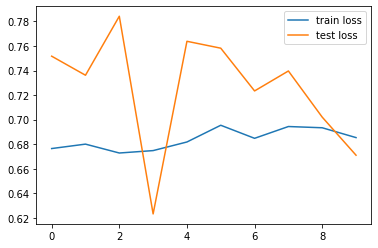

In [26]:
plot_metric(d_losses, "train loss")
plot_metric(g_losses, "test loss")

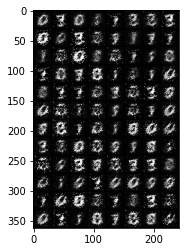

In [27]:
image_show("gan_images/1.png")

In [28]:
# train more to see the results

In [29]:
# image_show("gan_images/50.png")

In [30]:
# image_show("gan_images/100.png")

In [31]:
# image_show("gan_images/150.png")

In [32]:
# image_show("gan_images/200.png")